In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Part 1: Download data and set directories

In [ ]:
# Download data
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68616192/68606236 [==============================] - 1s 0us/step


In [ ]:
# Define paths to training and validation images
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

# Specify them by class
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with training dog pictures
val_cats_dir = os.path.join(val_dir, 'cats')      # directory with validation cat pictures
val_dogs_dir = os.path.join(val_dir, 'dogs')      # directory with validation dog pictures

In [ ]:
# Count how many of them are there
n_cats_train = len(os.listdir(train_cats_dir))
n_dogs_train = len(os.listdir(train_dogs_dir))

n_cats_val = len(os.listdir(val_cats_dir))
n_dogs_val = len(os.listdir(val_dogs_dir))

n_total_train = n_cats_train + n_dogs_train
n_total_val = n_cats_val + n_dogs_val

# Print some info
print('total training cat images:', n_cats_train)
print('total training dog images:', n_dogs_train)

print('total validation cat images:', n_cats_val)
print('total validation dog images:', n_dogs_val)
print("--")
print("Total training images:", n_total_train)
print("Total validation images:", n_total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Part 2: Define batch-generator process

In [ ]:
# Define some constants
batch_size = 8
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [ ]:
# Define generator objects for training and validation data
train_generator = ImageDataGenerator(rescale=1./255)
val_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
# Define method to load images from disk, apply rescaling, and resize them into specified size.
train_gen = train_generator.flow_from_directory(batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')
val_gen = val_generator.flow_from_directory(batch_size=batch_size,
                                            directory=val_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Part 3: Import pretrained model and warm it up

In [ ]:
# Import VGGnet pretrained on the ImageNet dataset
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
vgg_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
vgg_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
W, b = model1.layers[2].get_weights()
W2 = np.random.rand(2, 2, 128, 151)
W2[:, :, :, :150] = W
b2 = np.zeros(151,)
b2[:150] = b
model2.layers[2].set_weights([W2, b2])

In [ ]:
b.shape

(64,)

Weights: (3, 3, 64, 128)
bias: (128,)
Min and Max weights' values
	 -0.3359
	 0.4166


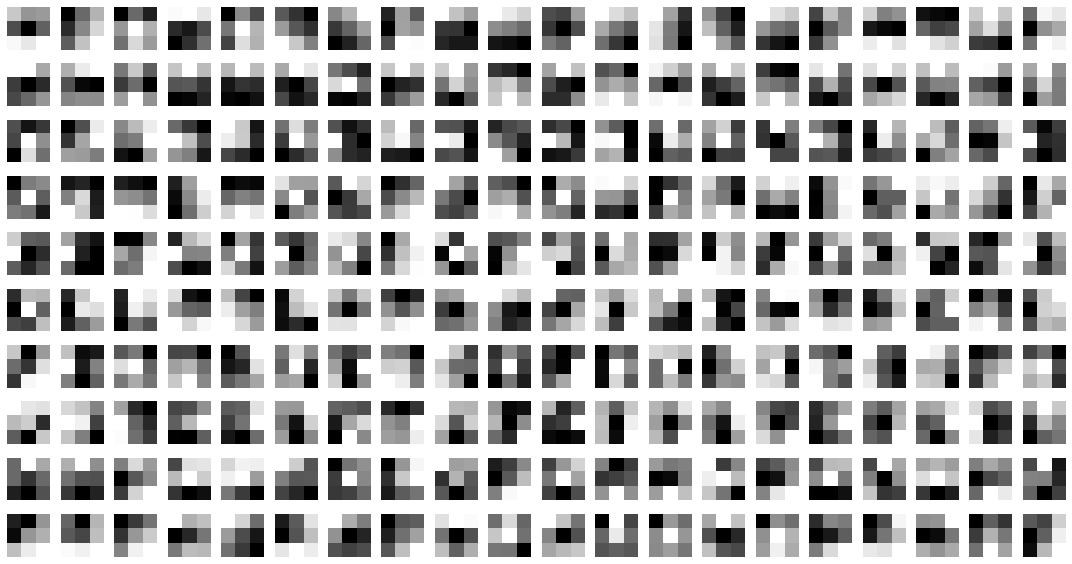

In [ ]:
# Get all kernels from the 4-th hidden layer of the vggnet
W, b = vgg_model.layers[4].get_weights()
print("Weights:", W.shape)
print("bias:", b.shape)

print("Min and Max weights' values")
print(f"\t {W.min():.4f}")
print(f"\t {W.max():.4f}")

# Visualize a few examples
ind_plot = 1
plt.figure(figsize=(15, 8))
for ind_filter in range(10): # iterate over first 10 kernels
  for ind_chann in range(20):# iterate over first 20 channels in each kernel
    # Get kernel and put its values between 0 and 1 for visualization only
    img = W[:, :, ind_chann, ind_filter].copy()
    img -= img.min()
    img /= img.max()
    # Plot it
    plt.subplot(10, 20, ind_plot)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    ind_plot += 1
plt.tight_layout()
plt.show()

In [ ]:
# Freeze all pre-trained kernels
vgg_model.trainable = False

In [ ]:
# Use pre-trained model as part of a full model - notice the number of trainable parameters
model = tf.keras.Sequential([
  vgg_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              8389632   
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 23,366,977
Trainable params: 8,652,289
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Compile it
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Train model
n_epochs = 10
history = model.fit(train_gen,
    steps_per_epoch=n_total_train//batch_size,
    epochs=n_epochs,
    validation_data=val_gen
)

Epoch 1/10
250/250 [==============================] - 22s 83ms/step - loss: 0.4324 - accuracy: 0.7940 - val_loss: 0.3154 - val_accuracy: 0.8750
Epoch 2/10
250/250 [==============================] - 20s 78ms/step - loss: 0.2544 - accuracy: 0.8920 - val_loss: 0.4553 - val_accuracy: 0.8250
Epoch 3/10
250/250 [==============================] - 20s 79ms/step - loss: 0.1844 - accuracy: 0.9280 - val_loss: 0.3405 - val_accuracy: 0.8680
Epoch 4/10
250/250 [==============================] - 20s 79ms/step - loss: 0.1360 - accuracy: 0.9425 - val_loss: 0.5380 - val_accuracy: 0.8380
Epoch 5/10
250/250 [==============================] - 20s 78ms/step - loss: 0.0947 - accuracy: 0.9625 - val_loss: 0.3816 - val_accuracy: 0.8680
Epoch 6/10
250/250 [==============================] - 20s 79ms/step - loss: 0.0630 - accuracy: 0.9775 - val_loss: 0.6100 - val_accuracy: 0.8490
Epoch 7/10
250/250 [==============================] - 20s 80ms/step - loss: 0.0441 - accuracy: 0.9825 - val_loss: 0.5286 - val_accuracy:

# Part 4: Fine tuning full model

In [ ]:
# Unfreeze model - notice the number of trainable parameters
model.trainable = True
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              8389632   
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 23,366,977
Trainable params: 23,366,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# We need to recompile after making any change in the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='bce', metrics=['accuracy'])

In [ ]:
# Fine tuning
n_epochs = 10
history = model.fit(train_gen,
    steps_per_epoch=n_total_train//batch_size,
    epochs=n_epochs,
    validation_data=val_gen
)

Epoch 1/10
250/250 [==============================] - 44s 167ms/step - loss: 0.9335 - accuracy: 0.6040 - val_loss: 0.4768 - val_accuracy: 0.7700
Epoch 2/10
250/250 [==============================] - 41s 165ms/step - loss: 0.4530 - accuracy: 0.7970 - val_loss: 0.3997 - val_accuracy: 0.8170
Epoch 3/10
250/250 [==============================] - 41s 166ms/step - loss: 0.3132 - accuracy: 0.8710 - val_loss: 0.5966 - val_accuracy: 0.8690
Epoch 4/10
250/250 [==============================] - 41s 165ms/step - loss: 0.2439 - accuracy: 0.9075 - val_loss: 0.4375 - val_accuracy: 0.8560
Epoch 5/10
250/250 [==============================] - 41s 165ms/step - loss: 0.2178 - accuracy: 0.9275 - val_loss: 0.2470 - val_accuracy: 0.9000
Epoch 6/10
250/250 [==============================] - 41s 165ms/step - loss: 0.2076 - accuracy: 0.9355 - val_loss: 0.3179 - val_accuracy: 0.9050
Epoch 7/10
250/250 [==============================] - 41s 165ms/step - loss: 0.1933 - accuracy: 0.9490 - val_loss: 0.3833 - val_ac

# Part 5: Visualize intermediate feature maps (signal response)

In [ ]:
# Now create a sub-model, from vgg, from input to 5th layer
from tensorflow.keras.models import Model
model2 = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[2].output)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


(8, 128, 128, 3)


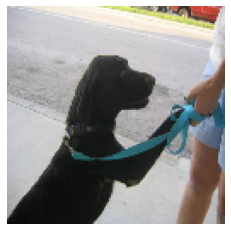

In [ ]:
# Generate a random batch, show first sample
sample_x, sample_y = next(train_gen)
print(sample_x.shape)

# Plot first sample
plt.imshow(sample_x[0])
plt.axis('off')
plt.show()

Shape of batch: (8, 128, 128, 64)
Shape of responses for one instance: (128, 128, 64)


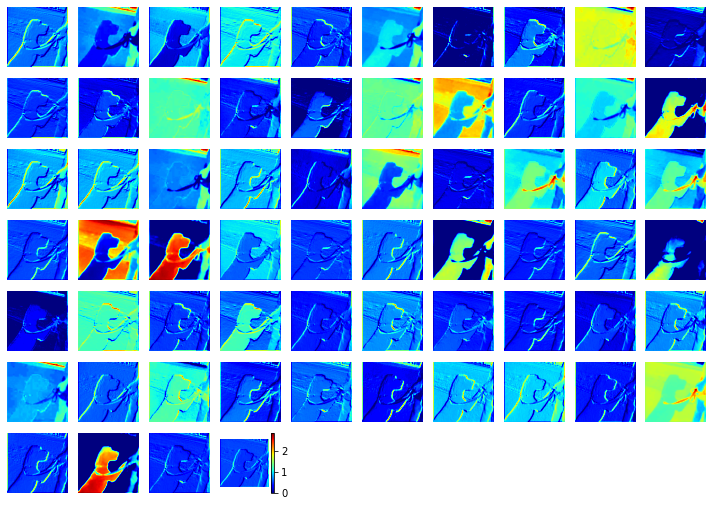

In [ ]:
# Predict on batch
feat_map = model2.predict(sample_x)
print(f"Shape of batch: {feat_map.shape}")

# Get feature maps (kernel responses) for 1st instance in the batch
a_sample = feat_map[0]
print(f"Shape of responses for one instance: {a_sample.shape}")

# Show a few feature maps (kernel responses)
plt.figure(figsize=(10, 10))
for ind in range(100):
  img = a_sample[:, :, ind].copy()
  img -= img.min()
  img /= img.max()
  plt.subplot(10, 10, ind+1)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# == Q ==
# 1. Investiga de qué manera se almacenan las capas (layers) de los modelos de tf.keras.
# 2. ¿Cómo imprimirías información sobre el número de capas que tiene un modelo?
# 3. Para el caso particular de transferencia de conocimiento, en el cual usas un modelo preentrenado
#    como segmento de un modelo más grande, ¿cambia la forma en que se almacenan las capas?
# 4. Explica el procedimiento para visualizar los kernels entrenados de alguna capa intermedia
#    (puedes ayudarte de líneas de código, pero la importancia de esta pregunta radica en que
#    puedas explicar qué hace cada línea de código).
# 5. De maner similar, explica el procedimiento para visualizar las salidas de las capas
#    intermedias (feature map o image response).